# Table of Contents
* [Submitting HITs](#Submitting-HITs)
	* [building html](#building-html)
	* [Building URLs for images on s3](#Building-URLs-for-images-on-s3)
	* [submitting HITs in groups](#submitting-HITs-in-groups)
		* [creates HITs, careful with this one](#creates-HITs,-careful-with-this-one)
* [Reviewing latest HITs](#Reviewing-latest-HITs)
	* [download](#download)
	* [process](#process)
* [Merging latest round of HITs into combined dataset](#Merging-latest-round-of-HITs-into-combined-dataset)
	* [Load previously pickled results](#Load-previously-pickled-results)
	* [Load prior complete dataset if not in memory](#Load-prior-complete-dataset-if-not-in-memory)
	* [Updating full dataset](#Updating-full-dataset)
	* [Working with full dataset](#Working-with-full-dataset)
* [Worker analysis](#Worker-analysis)
	* [Basic worker stats](#Basic-worker-stats)
		* [HIT duration for pricing](#HIT-duration-for-pricing)
	* [Identifying high and low consensus workers](#Identifying-high-and-low-consensus-workers)
	* [Messaging workers](#Messaging-workers)
* [HIT end-of-life](#HIT-end-of-life)
	* [Pickle latest results](#Pickle-latest-results)
	* [Pickle combined dataset](#Pickle-combined-dataset)
	* [Accepting and deleting HITs... careful with these](#Accepting-and-deleting-HITs...-careful-with-these)
* [End](#End)


In [1]:
%%capture
from __future__ import division
import numpy as np
import pandas as pd
import scipy.stats as st
import itertools
import math
from collections import Counter, defaultdict
%load_ext autoreload
%autoreload 2

import matplotlib as mpl
mpl.use("Agg")
import matplotlib.pylab as plt
#%matplotlib notebook
%matplotlib inline
%load_ext base16_mplrc
%base16_mplrc light default
plt.rcParams['figure.figsize'] = (16.0, 10.0)

import re
from datetime import datetime
import dateutil.parser as dt_parse
import pickle
import boto
from copy import deepcopy
import json
import os
import jinja2
from IPython.core.display import HTML

import boto.mturk.connection as tc
import boto.mturk.question as tq
from boto.mturk.qualification import PercentAssignmentsApprovedRequirement, Qualifications, Requirement

from keysTkingdom import mturk_ai2
from keysTkingdom import aws_tokes

import pdfextraction.amt_boto_modules as amt_util
# from tqa_utils import Evaluator

# Submitting HITs

## load dataset

In [2]:
dataset_root_dir = '/Users/schwenk/wrk/stb/dataset_releases/data_release_beta7/'
file_name = 'tqa_dataset_beta7_5.json'
data_file =  dataset_root_dir + file_name

# quest_evaluator = Evaluator(data_file)

with open(os.path.join(dataset_root_dir, file_name), 'r') as f:
    ck12_combined_dataset_raw = json.load(f)
ck12_combined_dataset = deepcopy(ck12_combined_dataset_raw)

In [29]:
## choosing sample

In [80]:
ndq_sample_lessons = np.random.choice([les for les in ck12_combined_dataset if len(les['questions']['nonDiagramQuestions']) > 10], 10)

In [81]:
[les['lessonName'] for les in ndq_sample_lessons]

[u'photosynthesis',
 u'the sun',
 u'air pollution',
 u'introduction to plants',
 u'characteristics of sound',
 u'topographic maps',
 u'history of life on earth',
 u'birds',
 u'hydrocarbons',
 u'water pollution']

In [68]:
dq_sample_lessons = np.random.choice([les for les in ck12_combined_dataset if les['questions']['diagramQuestions']], 10)

In [69]:
[les['lessonName'] for les in dq_sample_lessons]

[u'continental drift',
 u'stress in earths crust',
 u'cell structures',
 u'electric circuits',
 u'inside earth',
 u'cycles of matter',
 u'cell biology',
 u'fish',
 u'the respiratory system',
 u'changes of state']

In [99]:
testl = ndq_sample_lessons[0]

In [107]:
sampled_question_ids = np.random.choice(testl['questions']['diagramQuestions'].keys(), 10, replace=False)

In [109]:
len({k: testl['questions']['diagramQuestions'][k] for k in sampled_question_ids})

10

## building html

### code

In [431]:
import os
import json
import jinja2
import argparse

j2env = jinja2.Environment()

default_page_html = """
<!DOCTYPE html>
<html>
  <head>
    <style type="text/css">
       .container {
            max-width: 800px;
          }
    </style>
  </head>
  <body style=max-width: 100px>
    <div class="container">
      <h1>Lesson: {{lesson}}</h1>
      <ul>
        {% for topic in topics %}
        <p>
        </p>
        <h3>{{topic.0}}</h3>
        <p>{{topic.1}}</p>
        {% endfor %}
      </ul>
    </div>
    <script src="http://code.jquery.com/jquery-1.10.2.min.js"></script>
    <script src="http://netdna.bootstrapcdn.com/bootstrap/3.0.0/js/bootstrap.min.js"></script>
  </body>
</html>
"""

diagram_page_html = """
<!DOCTYPE html>
<html>
  <head>
    <style type="text/css">
       .container {
          }
    </style>
  </head>
  <body style=max-width: 100px>
    <div class="container">
      <h1>Lesson: {{lesson}}</h1>
      <ul>
        {% for topic in topics %}
        <p>
        </p>
        <p>{{topic}}</p>
        {% endfor %}
      </ul>
    </div>
    <script src="http://code.jquery.com/jquery-1.10.2.min.js"></script>
    <script src="http://netdna.bootstrapcdn.com/bootstrap/3.0.0/js/bootstrap.min.js"></script>
  </body>
</html>
"""


def make_lesson_data(lesson_json, rel_html_out_path=None):
    nested_text = []
    for topic, content in sorted(lesson_json['topics'].items(), key=lambda kv: kv[1]['globalID']):
        nested_text.append((content['topicName'], content['content']['text']))
        if content['content']['figures']:
            for figure in content['content']['figures']:
                image_link = '<img src="' + '../../' + figure['imagePath'] + '" width=500px>'
                image_caption = figure['caption']
                nested_text.append(('', image_link))
                nested_text.append(('', image_caption))
    
    for topic, content in lesson_json['adjunctTopics'].items():
        if topic == 'Vocabulary':
            nested_text.append((topic, ''))            
            for k, v in content.items():
                nested_text.append(('', k + ':  ' + v))
        else:
            nested_text.append((topic, content['content']['text']))
            if content['content']['figures']:
                for figure in content['content']['figures']:
                    image_link = '<img src="' + '../../' + figure['imagePath'] + '" width=500px>'
                    image_caption = figure['caption']
                    nested_text.append(('', image_link))
                    nested_text.append(('', image_caption))
    return nested_text



def make_lesson_wdq_data(lesson_json, rel_html_out_path, question_type='diagramQuestions'):
    nested_text = []
    for question in sorted(lesson_json['questions'][question_type].values(), key=lambda x: x['globalID']):
        image_link = '<img src="' + '../../' + question['imagePath'] + '" width=500px>'
        nested_text.append(image_link)
        nested_text.append(question['globalID'])
        being_asked = question['beingAsked']['processedText']
        nested_text.append(being_asked)
        for ac in sorted(question['answerChoices'].values(), key=lambda x: x['idStructural']):
            if ac['processedText'] == question['correctAnswer']['processedText']:
                nested_text.append('<font color="red"> ' + ' '.join([' ', ac['idStructural'], ac['processedText']]) + '</font>')
            else:
                nested_text.append(' '.join([' ', ac['idStructural'], ac['processedText']]))
        nested_text.append('')
    return nested_text


def make_lesson_wq_data(lesson_json, rel_html_out_path, question_type='diagramQuestions'):
    nested_text = []
    for question in sorted(lesson_json['questions'][question_type].values(), key=lambda x: x['globalID']):
        if question['questionType'] in ["Direct Answer"]:
            continue
        if question_type == 'diagramQuestion':
            image_link = '<img src="' + '../../' + question['imagePath'] + '" width=500px>'
            nested_text.append(image_link)
        nested_text.append(question['globalID'])
        being_asked = question['beingAsked']['processedText']
        nested_text.append(being_asked)
        for ac in sorted(question['answerChoices'].values(), key=lambda x: x['idStructural']):
            if 'correctAnswer' not in question.keys() or'processedText' not in question['correctAnswer'].keys():
                continue
            if question['correctAnswer']['processedText'] in [ac['processedText'], ac['idStructural'].replace('.', '').replace(')', '')]:
                nested_text.append('<font color="red"> ' + ' '.join([' ', ac['idStructural'], ac['processedText']]) + '</font>')
            else:
                nested_text.append(' '.join([' ', ac['idStructural'], ac['processedText']]))
        nested_text.append('')
    return nested_text


def make_lesson_diagram_description_data(lesson_json, rel_html_out_path):
    nested_text = []
    for description in sorted(list(lesson_json['instructionalDiagrams'].values()), key=lambda x: x['imagePath']):
        image_link = '<img src="' + '../../' + description['imagePath'] + '" width=500px>'
        nested_text.append(image_link)
        nested_text.append(description['imageName'])
        being_asked = description['processedText']
        nested_text.append(being_asked)
        nested_text.append('')
    return nested_text


def make_page_html(lesson_data, page_html, lesson_name, qid):
    return j2env.from_string(page_html).render(lesson=lesson_data[0], topics=lesson_data[1], lesson_name=lesson_name, qid=qid)


def display_lesson_html(lesson_json, lesson, page_type=None, html_output_dir=None, lesson_name=None, qid=None):
    if not page_type or page_type == 'lessons':
        lesson_data = (lesson, make_lesson_data(lesson_json, html_output_dir))
        page_html = default_page_html
    elif page_type == 'questions':
        being_asked, answer_choices = make_lesson_q_hit_data(lesson_json, html_output_dir, 'nonDiagramQuestions')
        lesson_data = (being_asked, answer_choices)
        page_html = question_page_html        
    elif page_type == 'diagram_questions':
        lesson_data = (lesson, make_lesson_wdq_data(lesson_json, html_output_dir))
        page_html = diagram_page_html
    elif page_type == 'diagram_descriptions':
        lesson_data = (lesson, make_lesson_diagram_description_data(lesson_json, html_output_dir))
        page_html = diagram_page_html
    lesson_html = make_page_html(lesson_data, page_html, lesson_name, qid)
    return lesson_html


def make_lesson_html(flexbook, lesson, page_html=default_page_html):
    lesson_json = flexbook[lesson]
    lesson_data = (lesson, make_lesson_data(lesson_json))
    lesson_html = make_page_html(lesson_data, page_html)
    return lesson_html


def render_html_from_dataset(ck12_combined_dataset):
    out_path = './html_renders' 
    render_types = ['lessons']
    for render in render_types:
        html_dir = os.path.join('html_renders', render)
        if not os.path.exists(html_dir):
            os.makedirs(html_dir)
        for lesson in ck12_combined_dataset:
            lesson_name = lesson['lessonName'].replace(' ', '_') + '_' + lesson['globalID'] + '.html' 
            if render == 'lessons':
                pass
            elif render == 'questions':
                pass
            elif not lesson['questions']['diagramQuestions']:
                continue
            lesson_html = display_lesson_html(lesson, lesson['lessonName'], render, out_path, s3_base + 'lessons/' + lesson_name)
            html_out_file = os.path.join(html_dir, lesson_name)
            with open(html_out_file, 'w') as f:
                f.write(lesson_html.encode('ascii', 'ignore').decode('utf-8'))
                
def render_question_html_from_dataset(ck12_combined_dataset):
    out_path = './html_renders' 
    html_dir = os.path.join('html_renders', 'questions')
    if not os.path.exists(html_dir):
        os.makedirs(html_dir)
    for lesson in ck12_combined_dataset:
        lesson_name = lesson['lessonName'].replace(' ', '_') + '_' + lesson['globalID'] + '.html'
        lesson_htmls = {}
        nonda_qs = {k: v for k, v in lesson['questions']['nonDiagramQuestions'].items() if v['questionType'] != 'Direct Answer'}
        sample_q_ids = np.random.choice(list(nonda_qs.keys()), 20, replace=False)
        for single_questions_id in sample_q_ids:
            lesson_single_question = deepcopy(lesson)
            single_questions = [nonda_qs[single_questions_id]]
            lesson_single_question['questions']['nonDiagramQuestions'] = single_questions
            lesson_htmls[single_questions_id] = display_lesson_html(lesson_single_question, lesson['lessonName'], 'questions', out_path, s3_base + 'lessons/' + lesson_name, single_questions_id)
        for qid, lesson_html in lesson_htmls.items():
            html_out_file = os.path.join(html_dir, qid + '_' + lesson_name)
            with open(html_out_file, 'w') as f:
                f.write(lesson_html.encode('ascii', 'ignore').decode('utf-8'))

In [432]:
def make_lesson_q_hit_data(lesson_json, rel_html_out_path, question_type='diagramQuestions'):
    nested_text = []
    for question in lesson_json['questions'][question_type]:
        if question['questionType'] in ["Direct Answer"]:
            continue
        if question_type == 'diagramQuestion':
            image_link = '<img src="' + '../../' + question['imagePath'] + '" width=500px>'
            nested_text.append(image_link)
        for ac in sorted(question['answerChoices'].values(), key=lambda x: x['idStructural']):
            nested_text.append(' '.join([' ', ac['idStructural'], ac['processedText']]))
    being_asked = question['beingAsked']['processedText']
    question_id = question['globalID']
    return being_asked, nested_text

In [ ]:
#       <form name='mturk_form' method='post' id='mturk_form' action='https://workerredsandbox.mturk.com/mturk/externalSubmit'>

In [446]:
question_page_html = """
<!DOCTYPE html>
<html>
  <head>
    <script type='text/javascript' src='https://s3.amazonaws.com/mturk-public/externalHIT_v1.js'></script>
    <title>Science Quiz Question</title>
    <style type="text/css">
       .container {
          }
    </style>
  </head>
  <body style=max-width: 100px>
    <div class="container">
    <p>Please answer the question below to the best of your ability. You can find <a href="{{lesson_name}}"> reference material</a> here that will help to answer the question. 
    There is a $0.30 bonus for answering the question correctly.
    </p>
      <h2>{{lesson}}</h2>
      <form name='mturk_form' method='post' id='mturk_form' action='https://www.mturk.com/mturk/externalSubmit'>
      <input type='hidden' value='' name='assignmentId' id='assignmentId'/>
      <input type="hidden" name="q_id" id="q_id" value = {{qid}}>
      <ul>
        {% for topic in topics %}
        <p>
        </p>
        <p>
        <input type="radio" name='results' value={{topic}} />
        {{topic}}
        </p>
        {% endfor %}
        <p><input type="submit" id="submitButton" value="Submit" /></p></form>
      </ul>
    </div>
    <script language="Javascript">turkSetAssignmentID();</script>
  </body>
</html>
"""

### running test

In [447]:
s3_base = 'https://s3.amazonaws.com/ai2-vision-textbook-dataset/human-baseline/html_renders/'

In [448]:
render_question_html_from_dataset(ndq_sample_lessons)

In [315]:
# render_html_from_dataset(ndq_sample_lessons)

## Building URLs for images on s3

In [457]:
questions_pages = os.listdir('./html_renders/questions/')

In [458]:
test_questions = questions_pages

In [459]:
questions_urls = [s3_base + 'questions/' + qfn for qfn in test_questions]

## submitting HITs in groups

In [476]:
## Switch between sandbox and the real world here ##
## DON'T FORGET to change submission POST request in the client ##

sandbox_host = 'mechanicalturk.sandbox.amazonaws.com' 
real_world_host = 'mechanicalturk.amazonaws.com'
mturk = tc.MTurkConnection(
    aws_access_key_id = mturk_ai2.access_key,
    aws_secret_access_key = mturk_ai2.access_secret_key,
    host = real_world_host,
    debug = 1 # debug = 2 prints out all requests.
)
current_account_balance = mturk.get_account_balance()[0]
print(current_account_balance) # a reminder of sandbox

$391.51


In [473]:
static_params = {
    'title': "Answer Science Questions with Provided Material (Large Bonus Potential!)",
    'description': "Answer science questions with a $0.30 bonus for a correct answer",
    'keywords': ['science', 'text' ,'question answering', 'reading comprehension'],
    'frame_height': 800,
    'amount': 0.02,
    'duration': 3600 * 1,
    'lifetime': 3600 * 24 * 2,
    'max_assignments': 3
}

### creates HITs, careful with this one

In [477]:
questions_to_submit = questions_urls
expected_cost = len(questions_to_submit) *  static_params['amount'] * static_params['max_assignments']
if float(current_account_balance.amount) < expected_cost:
    print('WARNING -- account balance is too low -- WARNING')
print('expect this batch of HITs to cost: $' + str(expected_cost))

expect this batch of HITs to cost: $12.0


uncomment cell below only when ready to submit

In [479]:
# amt_util.create_hits_from_pages(mturk, questions_to_submit, static_params)

# Reviewing latest HITs

## download

In [480]:
r_hits_current_batch = amt_util.get_completed_hits(mturk)
assignment_results_current_batch = amt_util.get_assignments(mturk, r_hits_current_batch)

In [358]:
r_hits_current_batch

In [481]:
len(assignment_results_current_batch)

2227

## process

In [482]:
print 'current assignment statuses'
print amt_util.get_assignment_statuses(assignment_results_current_batch)

current assignment statuses
Approved     6570
Submitted     111
dtype: int64


In [486]:
submitted_assignments = defaultdict(list)
for hitid, assignments in assignment_results_current_batch.items():
    for assignment in assignments:
        if assignment.AssignmentStatus == 'Submitted':
            submitted_assignments[hitid].append(assignment)

In [487]:
len(submitted_assignments)

37

In [489]:
assigment_worker_lookup = {}
for hit_id, hit_assignments in submitted_assignments.items():
        for assignment in hit_assignments:
            assigment_worker_lookup[assignment.AssignmentId]  = assignment.WorkerId

In [504]:
def process_raw_hits(assignments_by_hit):
    mechanical_turk_results = defaultdict(list)
    for hit_id, hit_assignments in assignments_by_hit.items():
        for assignment in hit_assignments:
            for answers in assignment.answers:
                q_id = answers[0].fields[0]
                q_ans = answers[1].fields[0]
                mechanical_turk_results[hit_id].append({
                    assignment.AssignmentId: {q_id: q_ans.replace('.', '')}}
                )
    return mechanical_turk_results

In [505]:
proc_results = process_raw_hits(submitted_assignments)

In [501]:
def make_answer_json(assignment_results):
    results = {}
    for hid, assignments in assignment_results.items():
        for assignment in assignments:
            for aid, result in assignment.items():
               results.update(result) 
    results_output = {k: v.replace('.', '') for k,v in results.items()}
    return results_output

In [502]:
res_json = make_answer_json(proc_results)

In [389]:
with open('turker_answers.json', 'w') as f:
    json.dump(res_json, f)

In [511]:
def make_results_df(raw_hit_results):
    col_names = ['qid', 'answer', 'hit_id', 'assignment_id']
    results_df = pd.DataFrame(columns=col_names)
    for hit_id, assignments in raw_hit_results.items():
        for assignment in assignments:
            for a_id, annotation in assignment.items():
                for diagram, rectangles in annotation.items():
                    for box in rectangles:
                        results_df.loc[len(results_df)] = \
                            [diagram, box, hit_id, a_id]
    return results_df

In [513]:
res_df = make_results_df(proc_results)

In [529]:
grouped_by_page = res_df.groupby(['qid'])

In [544]:
    grouped_by_page = res_df.groupby(['qid'])
    aggregated_df = grouped_by_page.agg(pd.DataFrame.sum)

In [560]:
sum(aggregated_df['answer'].apply(lambda x: st.mode(tuple(x))[1][0] < 3))

21

In [536]:
res_df

,qid,answer,hit_id,assignment_id
0,NDQ_002321,f,3Q9SPIIRWKMNQQ35YOAL5Y7MX47AWB,3FIJLY1B6V4VPSL6NKNKGP51DKQPFX
1,NDQ_002321,c,3Q9SPIIRWKMNQQ35YOAL5Y7MX47AWB,34FNN24DCN9XW9KI8V6U7470SVG5YP
2,NDQ_002321,f,3Q9SPIIRWKMNQQ35YOAL5Y7MX47AWB,354P56DE9L3FNRMSXIT2N2XV2GFS7D
3,NDQ_002305,b,3TRB893CSKA9A2F7CGUJ94J828BG7R,3WSELTNVR42YLTX5TLAC7YV757YTAT
4,NDQ_002305,b,3TRB893CSKA9A2F7CGUJ94J828BG7R,3NQL1CS15S8EU3ZXEMO7B21Z5JHYVO
5,NDQ_002305,b,3TRB893CSKA9A2F7CGUJ94J828BG7R,3X66WABAJXIUW3CE06WVL72C93ZG3C
6,NDQ_014220,e,3XBXDSS889JJB9ZZ5KVXGV140ICLXX,3PW9OPU9PRK876QSENXNVATE10G12M
7,NDQ_014220,d,3XBXDSS889JJB9ZZ5KVXGV140ICLXX,3YT88D1N09YZYP8XQXHAJZU5GKGK3J
8,NDQ_014220,d,3XBXDSS889JJB9ZZ5KVXGV140ICLXX,3IAS3U3I0GG9K48KGKQC1M6NNC82B7
9,NDQ_015945,b,3NZ1E5QA601YWHTD81N8A9EFVPOB5Q,3FE7TXL1LJNWOAA9Z2N2WB1M9C82QI


In [534]:
def make_consensus_df(results_df, no_consensus_flag):
    grouped_by_page = results_df.groupby(['qid'])
    aggregated_df = grouped_by_page.agg(pd.DataFrame.mode)
#     aggregated_df.drop([ 'page', 'box_id', 'worker_id'], axis=1, inplace=True)
    aggregated_df = aggregated_df.fillna(no_consensus_flag)
    consensus_results_df = aggregated_df.reset_index()
#     consensus_results_df.drop('level_2', axis=1, inplace=True)
    return consensus_results_df

In [535]:
make_consensus_df(res_df, 'DIS')

ValueError: cannot copy sequence with size 4 to array axis with dimension 1

In [523]:
res_df

,qid,answer,hit_id,assignment_id
0,NDQ_002321,f,3Q9SPIIRWKMNQQ35YOAL5Y7MX47AWB,3FIJLY1B6V4VPSL6NKNKGP51DKQPFX
1,NDQ_002321,c,3Q9SPIIRWKMNQQ35YOAL5Y7MX47AWB,34FNN24DCN9XW9KI8V6U7470SVG5YP
2,NDQ_002321,f,3Q9SPIIRWKMNQQ35YOAL5Y7MX47AWB,354P56DE9L3FNRMSXIT2N2XV2GFS7D
3,NDQ_002305,b,3TRB893CSKA9A2F7CGUJ94J828BG7R,3WSELTNVR42YLTX5TLAC7YV757YTAT
4,NDQ_002305,b,3TRB893CSKA9A2F7CGUJ94J828BG7R,3NQL1CS15S8EU3ZXEMO7B21Z5JHYVO
5,NDQ_002305,b,3TRB893CSKA9A2F7CGUJ94J828BG7R,3X66WABAJXIUW3CE06WVL72C93ZG3C
6,NDQ_014220,e,3XBXDSS889JJB9ZZ5KVXGV140ICLXX,3PW9OPU9PRK876QSENXNVATE10G12M
7,NDQ_014220,d,3XBXDSS889JJB9ZZ5KVXGV140ICLXX,3YT88D1N09YZYP8XQXHAJZU5GKGK3J
8,NDQ_014220,d,3XBXDSS889JJB9ZZ5KVXGV140ICLXX,3IAS3U3I0GG9K48KGKQC1M6NNC82B7
9,NDQ_015945,b,3NZ1E5QA601YWHTD81N8A9EFVPOB5Q,3FE7TXL1LJNWOAA9Z2N2WB1M9C82QI


# Merging latest round of HITs into combined dataset 

## Load previously pickled results

In [383]:
batch_number = 7

with open('./store_hit_results_metadata/group_' + str(batch_number) + '/hit_info.pkl') as f:
    r_hits_previous_batch = pickle.load(f)
    
with open('./store_hit_results_metadata/group_' + str(batch_number) + '/assignment_info.pkl') as f:
    assignment_results_previous_batch = pickle.load(f)
    
# with open('./store_hit_results_metadata/group_' + str(batch_number) + '/raw_res.pkl') as f:
#     raw_hit_results_previous_batch = pickle.load(f)

In [397]:
# combined_results_batch = pd.read_pickle(data_pickled_dir + 'complete_df.pkl')
# combined_consensus_batch = pd.read_pickle(data_pickled_dir + 'consensus_df.pkl')

In [405]:
missing_hits = set(assignment_results_previous_batch.keys()).difference(assignment_results_current_batch.keys())
missing_hits_assignments = {k: v for k, v in assignment_results_previous_batch.items() if k in missing_hits}

## Load prior complete dataset if not in memory

In [2]:
data_pickled_dir = './store_hit_results_metadata/group_latest_combined/' 

In [3]:
combined_results_df = pd.read_pickle(data_pickled_dir + 'complete_df.pkl')
combined_consensus_df = pd.read_pickle(data_pickled_dir + 'consensus_df.pkl')
combined_consensus_with_workerid_df = pd.read_pickle(data_pickled_dir + 'consensus_df_w_workers.pkl') 

## Updating full dataset

In [426]:
combined_results_df = combined_results_df.append(results_df_previous_batch)
combined_consensus_df = combined_consensus_df.append(consensus_prev)
combined_consensus_with_workerid_df = combined_consensus_with_workerid_df.append(consensus_prevww)

In [4]:
%%capture
no_consensus_hits = combined_consensus_df[combined_consensus_df['category'] == 'No Consensus']

## Working with full dataset

# Worker analysis

## Basic worker stats

In [1726]:
results_df

,diagram,rectangle,hit_id,assignment_id,worker_id
0,parts_cell_1182.png,"[[283, 192], [447, 238]]",3SA4EMRVJV39U1MGLCYP6KPFULH0PX,3BDCF01OGXVJNV1XRULS5F5Z4B6LYG,A1017VP86SLXRB
1,parts_cell_1182.png,"[[115, 245], [273, 285]]",3SA4EMRVJV39U1MGLCYP6KPFULH0PX,3BDCF01OGXVJNV1XRULS5F5Z4B6LYG,A1017VP86SLXRB
2,parts_cell_1182.png,"[[703, 122], [840, 162]]",3SA4EMRVJV39U1MGLCYP6KPFULH0PX,3BDCF01OGXVJNV1XRULS5F5Z4B6LYG,A1017VP86SLXRB
3,parts_cell_1182.png,"[[958, 88], [1068, 133]]",3SA4EMRVJV39U1MGLCYP6KPFULH0PX,3BDCF01OGXVJNV1XRULS5F5Z4B6LYG,A1017VP86SLXRB
4,parts_cell_1182.png,"[[1165, 98], [1302, 142]]",3SA4EMRVJV39U1MGLCYP6KPFULH0PX,3BDCF01OGXVJNV1XRULS5F5Z4B6LYG,A1017VP86SLXRB
5,parts_cell_1182.png,"[[1243, 175], [1418, 288]]",3SA4EMRVJV39U1MGLCYP6KPFULH0PX,3BDCF01OGXVJNV1XRULS5F5Z4B6LYG,A1017VP86SLXRB
6,parts_cell_1182.png,"[[1192, 822], [1423, 865]]",3SA4EMRVJV39U1MGLCYP6KPFULH0PX,3BDCF01OGXVJNV1XRULS5F5Z4B6LYG,A1017VP86SLXRB
7,parts_cell_1182.png,"[[987, 945], [1397, 1003]]",3SA4EMRVJV39U1MGLCYP6KPFULH0PX,3BDCF01OGXVJNV1XRULS5F5Z4B6LYG,A1017VP86SLXRB
8,parts_cell_1182.png,"[[710, 1025], [862, 1068]]",3SA4EMRVJV39U1MGLCYP6KPFULH0PX,3BDCF01OGXVJNV1XRULS5F5Z4B6LYG,A1017VP86SLXRB
9,parts_cell_1182.png,"[[497, 1038], [642, 1073]]",3SA4EMRVJV39U1MGLCYP6KPFULH0PX,3BDCF01OGXVJNV1XRULS5F5Z4B6LYG,A1017VP86SLXRB


In [1714]:
print 'number of unique workers:'
pd.unique(results_df['worker_id']).shape[0]

number of unique workers:


177

In [1724]:
grouped_by_worker = results_df.groupby('worker_id')

In [1737]:
grouped_by_worker['rectangle'].aggregate(len)

worker_id
A03922113RU44GENR8ATX     146
A1017VP86SLXRB            862
A10443E11ZWEHJ             13
A107QUL9WE39ZV            105
A10PVSMU1UBP8N            292
A111JI6APXR6QV             41
A11MPIAKPRMF9T             61
A122E99M2DQY1G             39
A127F80LLYOQ22              2
A13LXDXAWD5DSY           1369
A13PFEJFK3DI9B            724
A14YUE2S0RRKY1             30
A150BOXII7BKNP             43
A154D85W3BLY4U            629
A15CDKMH6YDJ39             21
A16DZUAE29Z21H            160
A16PK8DLMV0XLW            949
A18ZUFGMNOVI2Y           1241
A198X28FHY2OY0            422
A19GQT4YCUWHIO             65
A19ZOKX8M6VWOO            191
A1D4I1QYL9713I            603
A1D4Z17JF8TE4Y            485
A1EFMDT1U0TBPV             10
A1EGJBJBFBZJBA            864
A1G3G0YQ80PTL9            235
A1HC5X6E6ZGINB            119
A1IM9SPV7X9P6W            508
A1ISG85JD2NXKK             63
A1M1T2EF4Y2IW8             39
                         ... 
AB66CTVQ90RCV              68
AB6F473EMJD8Y             236


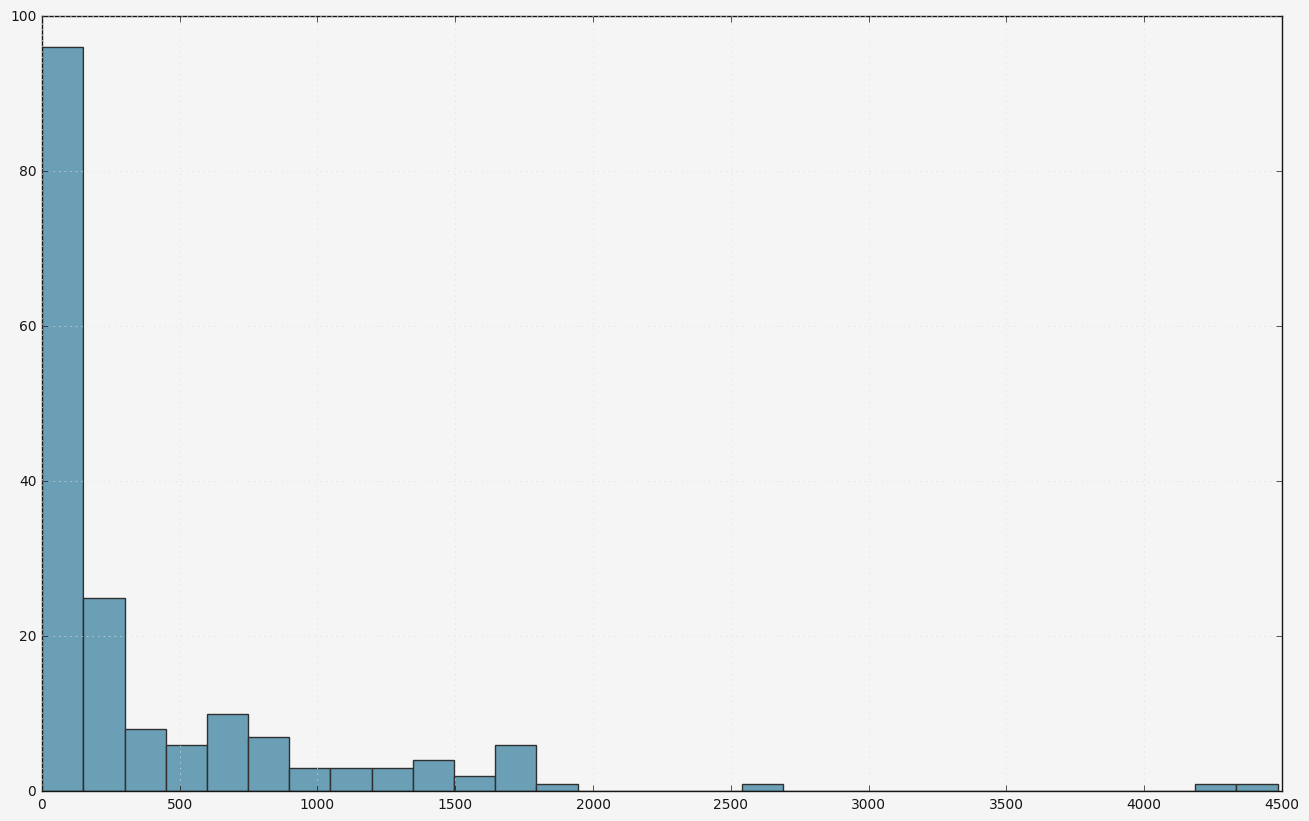

In [1716]:
_ = results_df['worker_id'].value_counts().hist(bins= 30)

### HIT duration for pricing

In [1718]:
task_duration_seconds = []
for hit_id, assignments in assignment_results_current_batch.items():
    for assignment in assignments:
        hit_duration = dt_parse.parse(assignment.SubmitTime) - dt_parse.parse(assignment.AcceptTime)
        task_duration_seconds.append(hit_duration.seconds)

In [1719]:
task_duration_series = pd.Series(task_duration_seconds)

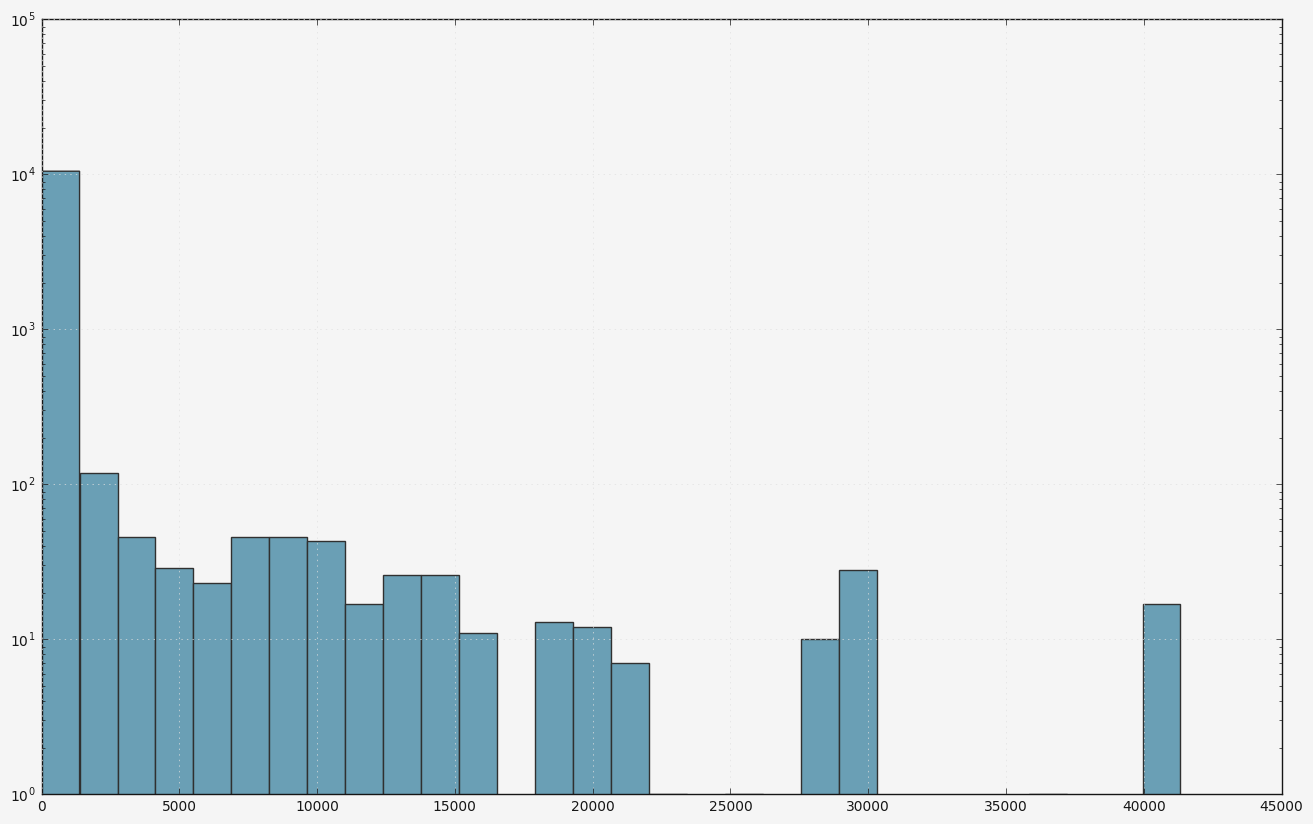

In [1720]:
_ = task_duration_series.hist(bins=30, log=True)

In [1721]:
winsorized_durations = [t for t in task_duration_seconds if t < 300]
w_duration_series = pd.Series(winsorized_durations)

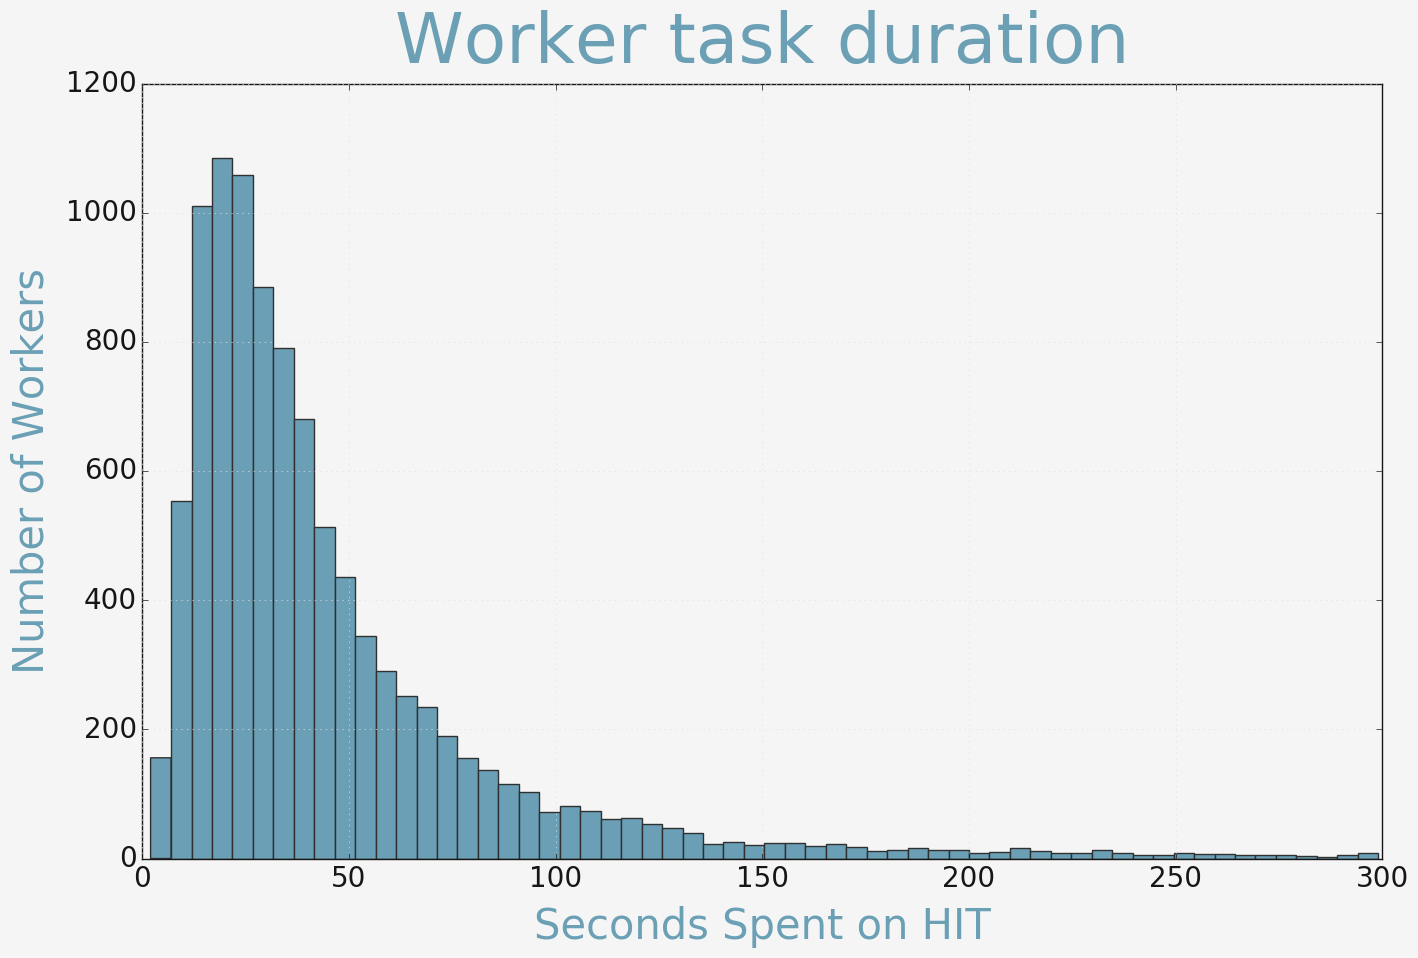

In [1722]:
_ = pd.Series(w_duration_series).hist(bins=60)
plt.title('Worker task duration', fontsize=50, verticalalignment='bottom', color = b16_colors.b)
plt.ylabel("Number of Workers", fontsize=30, labelpad=10, color = b16_colors.b)
plt.xlabel("Seconds Spent on HIT", fontsize=30, labelpad=10, color = b16_colors.b)
plt.tick_params(axis='x', which='major', labelsize=20)
plt.tick_params(axis='y', which='major', labelsize=20)

In [1723]:
print 'duration mode= ' + str(w_duration_series.mode().values[0])
print 'duration median= ' + str(w_duration_series.median())

duration mode= 22
duration median= 33.0


## Identifying high and low consensus workers

In [113]:
consensus_with_workerid_df_this_batch = amt_util.make_consensus_df_w_worker_id(results_df_current_batch, consensus_results_df_current_batch)

In [138]:
len(pd.unique(worker_conflicts['worker_id']))

175

In [113]:
worker_conflicts = combined_consensus_with_workerid_df[combined_consensus_with_workerid_df['category'] != combined_consensus_with_workerid_df['consensus_category']]
all_worker_counts = combined_results_df['worker_id'].value_counts()
bad_worker_counts = worker_conflicts['worker_id'].value_counts()
worker_quality_df = pd.DataFrame([all_worker_counts, bad_worker_counts]).T
worker_quality_df.columns=['submitted', 'incorrect']
worker_quality_df['flaw_ratio'] = worker_quality_df['incorrect']/worker_quality_df['submitted']

good_workers = worker_quality_df.sort_values('flaw_ratio', ascending= True).index.tolist()

suspect_workers = worker_quality_df.sort_values('flaw_ratio', ascending= False).index.tolist()

worker_quality_df.sort_values('flaw_ratio', ascending= True).head(10)

,submitted,incorrect,flaw_ratio
A3JOFB6Z65I37Q,124.0,2.0,0.016129
A2HTN7HCNBQ8V4,157.0,3.0,0.019108
A22FK64IWET30E,45.0,1.0,0.022222
AEWGY34WUIA32,1538.0,40.0,0.026008
ASB8T0H7L99RF,507.0,14.0,0.027613
AMA18W8F60Y2J,100.0,3.0,0.030000
A2YY1ZR7Z4VT4M,1517.0,54.0,0.035597
AJFVK3O1D7SPE,1141.0,42.0,0.036810
A10M8ULK8QMRU6,27.0,1.0,0.037037
A2HM35CWB7IIFM,26.0,1.0,0.038462


I became concerned that I missed the perfect performers, but as I suspected perfect workers only did 1-2 HITs at most

In [147]:
aw_set = set(all_worker_counts.index)
bw_set = set(bad_worker_counts.index)
flawless_workers = list(aw_set.difference(bw_set))
all_worker_counts[all_worker_counts.index.isin(best_workers)]

A1N8SWL57W43PV    42
A161I6SGXNY96M    31
A1VL844FUMGC8W    24
A18U9WMYFYJPR6    24
A2U0QL8K0NTGS5    23
A1P47Q6LZPLQ6P    22
A2VL602367WQQW    20
A4UVNGSXE2ANA     20
AFE8IXO7K303F     19
A1HRHFU7KTS0KW    16
Name: worker_id, dtype: int64

In [156]:
bad_and_prolific_workers = worker_quality_df.sort_values('flaw_ratio', ascending= False).head(25).sort_values('incorrect', ascending= False)

In [176]:
bad_and_prolific_to_review = list(bad_and_prolific_workers[:15].index)

## Messaging workers

In [118]:
subject = "More science book annotation HITs are available"
message = """
Hello, 

If you're receiving this message you were among the top performers on the first group HITs I submitted.
I've submitted another group of HITs, with more to follow in the next few days. 
This task is slightly different from the first, so please review the new instructions before jumping in.

Happy to get any feedback you might have for the new HITs.
"""

In [119]:
_ = mturk.notify_workers(good_workers[:20], subject, message)

# HIT end-of-life

## Pickle latest results

In [1739]:
#reset as needed
gn = 3

In [1740]:
gn

3

In [1743]:
next_group = gn + 1
group_n = '_' + str(gn) + '/'

temp_store_dir = './store_hit_results_metadata/loc_group'
try:
    os.mkdir(temp_store_dir + group_n)
except:
    OSError
    
result_file_name = 'hit_info.pkl'
assignment_file_name = 'assignment_info.pkl'
raw_results_file_name = 'raw_res.pkl'
complete_results_file = 'complete_df.pkl'
consensus_results_file = 'consensus_df.pkl'

amt_util.pickle_this(r_hits_current_batch, temp_store_dir + group_n + result_file_name)
amt_util.pickle_this(assignment_results_current_batch, temp_store_dir + group_n + assignment_file_name)
amt_util.pickle_this(raw_hit_results_current_batch, temp_store_dir + group_n + raw_results_file_name)
results_df.to_pickle(temp_store_dir + group_n + complete_results_file)
print 'saved HIT batch number ' + str(gn)
print 'now onto batch ' +str(next_group) 
gn = next_group

saved HIT batch number 3
now onto batch 4


## Pickle combined dataset

In [429]:
temp_store_dir = './store_hit_results_metadata/group'
group_n = '_latest_combined/'
try:
    os.mkdir(temp_store_dir + group_n)
except:
    OSError
    
complete_results_file = 'complete_df.pkl'
consensus_results_file = 'consensus_df.pkl'
consensus_results_file_w_workers = 'consensus_df_w_workers.pkl'

combined_results_df.to_pickle(temp_store_dir + group_n + complete_results_file)
combined_consensus_df.to_pickle(temp_store_dir + group_n + consensus_results_file)
combined_consensus_with_workerid_df.to_pickle(temp_store_dir + group_n + consensus_results_file_w_workers)

## Accepting and deleting HITs... careful with these

Uncomment only when ready to accept or delete hits

reject assignments carefully

In [321]:
# number_rejected_assignments, number_rejected_workers = amt_util.reject_assignments(mturk, workers_to_ban, combined_consensus_with_workerid_df)
# print 'rejecting ' + str(number_rejected_assignments) + ' assignments' + ' from ' + str(number_rejected_workers) + ' workers'

In [484]:
flattened_assignments = [item for sublist in assignment_results_current_batch.values() for item in sublist]

len(flattened_assignments)

# amt_util.get_assignment_statuses(assignment_results_current_batch)

6681

In [483]:
amt_util.get_assignment_statuses(assignment_results_current_batch)

Approved     6570
Submitted     111
dtype: int64

In [399]:
# amt_util.accept_hits(mturk, flattened_assignments)

In [437]:
# amt_util.delete_some_hits(mturk, assignment_results_current_batch_post_)

In [410]:
def pay_bonuses(correct_assignments):
    bonus_ammount = boto.mturk.price.Price(0.30)
    bonus_reason_template = 'For correctly answering the science question given in assignment {}.'
    for a_id, w_id in correct_assignments.items():
        bonus_reason = bonus_reason_template.format(str(a_id))
        mturk.grant_bonus(w_id, a_id, bonus_ammount, bonus_reason)

In [465]:
# amt_util.delete_all_hits(mturk)

# End